## SECTION C

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train_dataset_cifar10 = datasets.CIFAR10(root='./cifar10_dataset', train=True, download=True, transform=transform)
# test_dataset_cifar10 = datasets.CIFAR10(root='./cifar10_dataset', train=False, download=True, transform=transform)

In [3]:
# # visualize sample image for each class along with label name

# # get class names
# class_names = train_dataset_cifar10.classes

# # get one image for each class
# class_images = []
# for i in range(10):
#     for image, label in train_dataset_cifar10:
#         if label == i:
#             class_images.append(image)
#             break

# # plot images

# fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# for i in range(10):
#     ax = axs[i // 5, i % 5]
#     ax.imshow(class_images[i].permute(1, 2, 0).numpy())
#     ax.set_title(class_names[i])
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

<h3 align='center'>Part 1</h3>

In [4]:
# selecting the classes - airplane, automobile, and bird
selected_classes = [0, 1, 2]
class_dict = {0: 'airplane', 1: 'automobile', 2: 'bird'}

# setting seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class CustomCIFAR10Dataset(Dataset):
    def __init__(self, train=True, classes=None):
        # loading the CIFAR-10 dataset
        self.cifar10_dataset = datasets.CIFAR10(root='./cifar10_dataset', train=train, download=True, transform=transform)
        self.classes = classes

        # filtering for selected classes
        self.filtered_indices = [i for i, label in enumerate(self.cifar10_dataset.targets) if label in self.classes]
        self.filtered_dataset = Subset(self.cifar10_dataset, self.filtered_indices)
        
        if train:

            # counting class distribution before splitting
            class_count = {cls: 0 for cls in classes}
            for i in self.filtered_indices:
                class_count[self.cifar10_dataset.targets[i]] += 1
            print(f"Class distribution before split: {class_count}")
            print(f"Dataset size before split: {len(self.filtered_dataset)}")

            # performing stratified train-val split
            train_indices, val_indices = train_test_split(range(len(self.filtered_indices)),
                test_size=0.2, stratify=[self.cifar10_dataset.targets[i] for i in self.filtered_indices], random_state=42)
            self.train_data = Subset(self.filtered_dataset, train_indices)
            self.val_data = Subset(self.filtered_dataset, val_indices)

            # counting class distribution after splitting
            train_class_count = {cls: 0 for cls in classes}
            val_class_count = {cls: 0 for cls in classes}
            for i in train_indices:
                train_class_count[self.cifar10_dataset.targets[self.filtered_indices[i]]] += 1
            for i in val_indices:
                val_class_count[self.cifar10_dataset.targets[self.filtered_indices[i]]] += 1

            print(f"Class distribution in train dataset: {train_class_count}")
            print(f"Class distribution in validation dataset: {val_class_count}")
            print(f"Train dataset size: {len(self.train_data)}")
            print(f"Validation dataset size: {len(self.val_data)}")

        else:
            self.test_data = self.filtered_dataset
            test_class_count = {cls: 0 for cls in classes}
            for i in self.filtered_indices:
                test_class_count[self.cifar10_dataset.targets[i]] += 1

            print(f"Class distribution in test dataset: {test_class_count}")
            print(f"Test dataset size: {len(self.test_data)}")

    def get_train_data(self):
        return self.train_data

    def get_val_data(self):
        return self.val_data

    def get_test_data(self):
        return self.test_data

    def __len__(self):
        if hasattr(self, 'train_data'):
            return len(self.train_data)  
        elif hasattr(self, 'val_data'):
            return len(self.val_data)  
        else:
            return len(self.test_data) 

    def __getitem__(self, idx):
        if hasattr(self, 'train_data') and self.train_data is not None:
            return self.train_data[idx]
        elif hasattr(self, 'val_data') and self.val_data is not None:
            return self.val_data[idx]
        elif hasattr(self, 'test_data') and self.test_data is not None:
            return self.test_data[idx]
        else:
            raise ValueError("Dataset is not properly initialized.")

In [5]:
custom_train_dataset = CustomCIFAR10Dataset(True, selected_classes)
print()
custom_test_dataset = CustomCIFAR10Dataset(False, selected_classes)
print()

# preparing train, validation, and test datasets
train_data = custom_train_dataset.get_train_data()
val_data = custom_train_dataset.get_val_data()
test_data = custom_test_dataset.get_test_data()

# creating data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Train Dataset Size: {len(train_loader.dataset)}")
print(f"Validation Dataset Size: {len(val_loader.dataset)}")
print(f"Test Dataset Size: {len(test_loader.dataset)}")

Files already downloaded and verified
Class distribution before split: {0: 5000, 1: 5000, 2: 5000}
Dataset size before split: 15000
Class distribution in train dataset: {0: 4000, 1: 4000, 2: 4000}
Class distribution in validation dataset: {0: 1000, 1: 1000, 2: 1000}
Train dataset size: 12000
Validation dataset size: 3000

Files already downloaded and verified
Class distribution in test dataset: {0: 1000, 1: 1000, 2: 1000}
Test dataset size: 3000

Train Dataset Size: 12000
Validation Dataset Size: 3000
Test Dataset Size: 3000


<h3 align='center'>Part 2</h3>

Visualizing 5 images for each class from the training dataset:


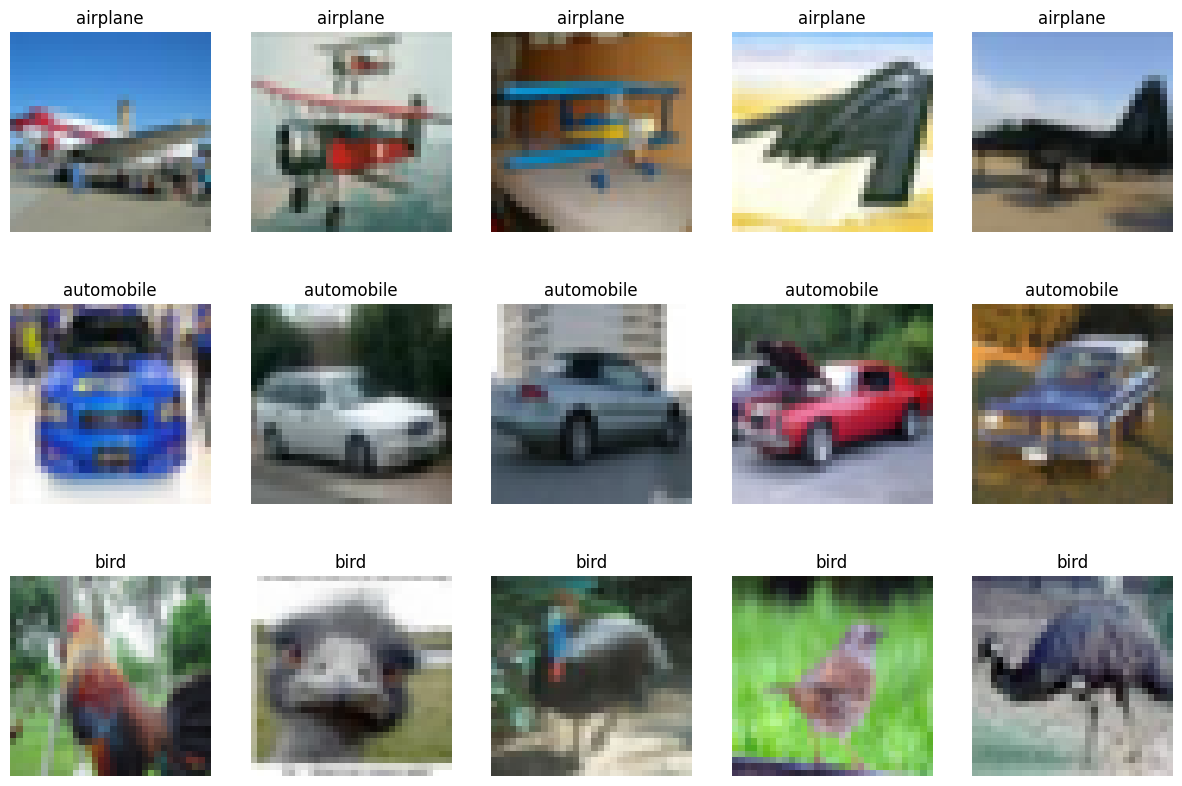

Visualizing 5 images for each class from the validation dataset:


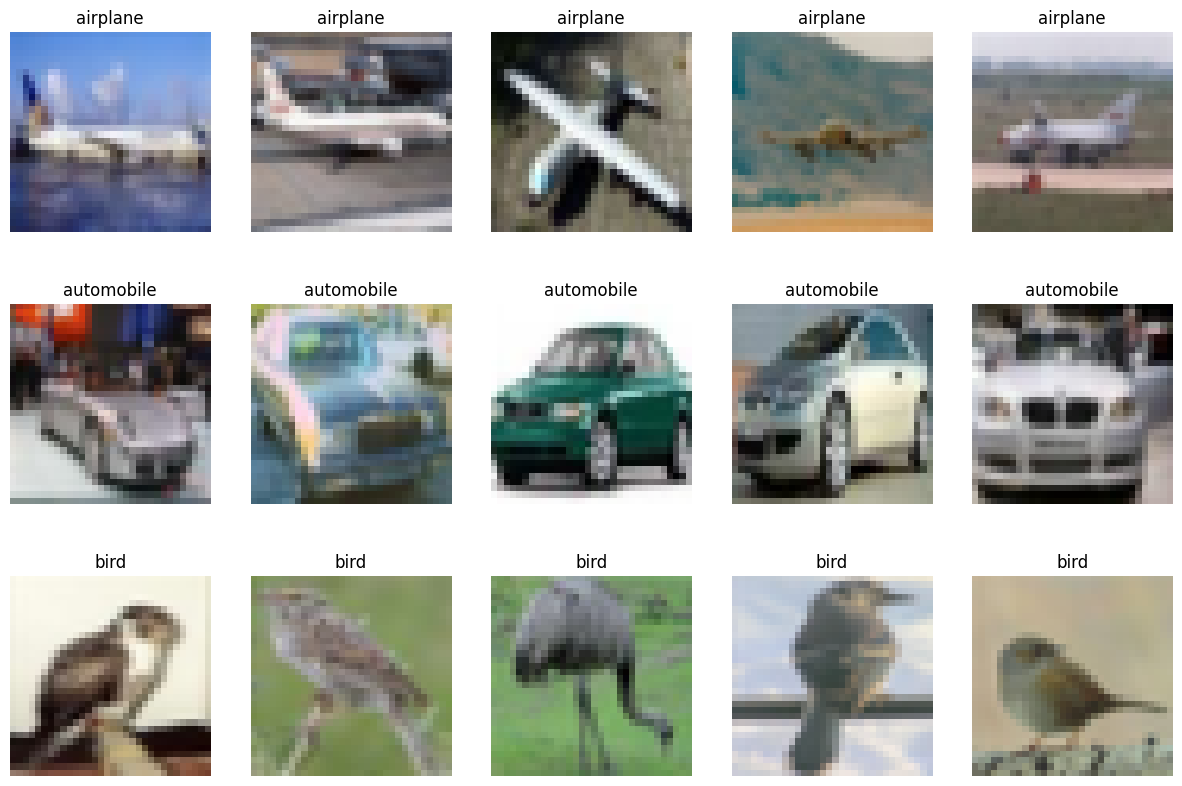

In [6]:
class_images = {cls: [] for cls in class_dict.keys()}

# collecting 5 images for each class
for img, label in train_data:
    if label in class_images and len(class_images[label]) < 5:
        class_images[label].append(img)
    if all(len(class_images[cls]) == 5 for cls in class_images):
        break

print("Visualizing 5 images for each class from the training dataset:")
fig, axes = plt.subplots(len(class_dict), 5, figsize=(15, 10))
for i, cls in enumerate(class_dict.keys()):
    for j, img in enumerate(class_images[cls]):
        ax = axes[i, j]
        img = img / 2 + 0.5 
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  
        ax.axis('off')
        ax.set_title(f'{class_dict[cls]}')

plt.show()

class_images = {cls: [] for cls in class_dict.keys()}

# collecting 5 images for each class
for img, label in val_data:
    if label in class_images and len(class_images[label]) < 5:
        class_images[label].append(img)
    if all(len(class_images[cls]) == 5 for cls in class_images):
        break

print("Visualizing 5 images for each class from the validation dataset:")
fig, axes = plt.subplots(len(class_dict), 5, figsize=(15, 10))
for i, cls in enumerate(class_dict.keys()):
    for j, img in enumerate(class_images[cls]):
        ax = axes[i, j]
        img = img / 2 + 0.5 
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  
        ax.axis('off')
        ax.set_title(f'{class_dict[cls]}')

plt.show()


<h3 align='center'>Part 3</h3>

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(512, 16) 
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x) 
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(class_dict))
print(model)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [8]:
# it = next(iter(train_loader))
# model.forward(it[0])

<h3 align='center'>Part 4</h3>

In [9]:
import torch.optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

torch.save(model.state_dict(), "CNNmodel.pth")
print('Finished Training')

Epoch 1/15
  Training Loss: 0.6974, Training Accuracy: 0.7037
  Validation Loss: 0.5578, Validation Accuracy: 0.7740
Epoch 2/15
  Training Loss: 0.5010, Training Accuracy: 0.8018
  Validation Loss: 0.4752, Validation Accuracy: 0.8123
Epoch 3/15
  Training Loss: 0.4350, Training Accuracy: 0.8257
  Validation Loss: 0.4230, Validation Accuracy: 0.8380
Epoch 4/15
  Training Loss: 0.4030, Training Accuracy: 0.8442
  Validation Loss: 0.4063, Validation Accuracy: 0.8430
Epoch 5/15
  Training Loss: 0.3777, Training Accuracy: 0.8530
  Validation Loss: 0.3926, Validation Accuracy: 0.8533
Epoch 6/15
  Training Loss: 0.3579, Training Accuracy: 0.8611
  Validation Loss: 0.3697, Validation Accuracy: 0.8607
Epoch 7/15
  Training Loss: 0.3463, Training Accuracy: 0.8667
  Validation Loss: 0.3573, Validation Accuracy: 0.8660
Epoch 8/15
  Training Loss: 0.3193, Training Accuracy: 0.8773
  Validation Loss: 0.3475, Validation Accuracy: 0.8667
Epoch 9/15
  Training Loss: 0.3050, Training Accuracy: 0.8850
  

<h3 align='center'>Part 5</h3>

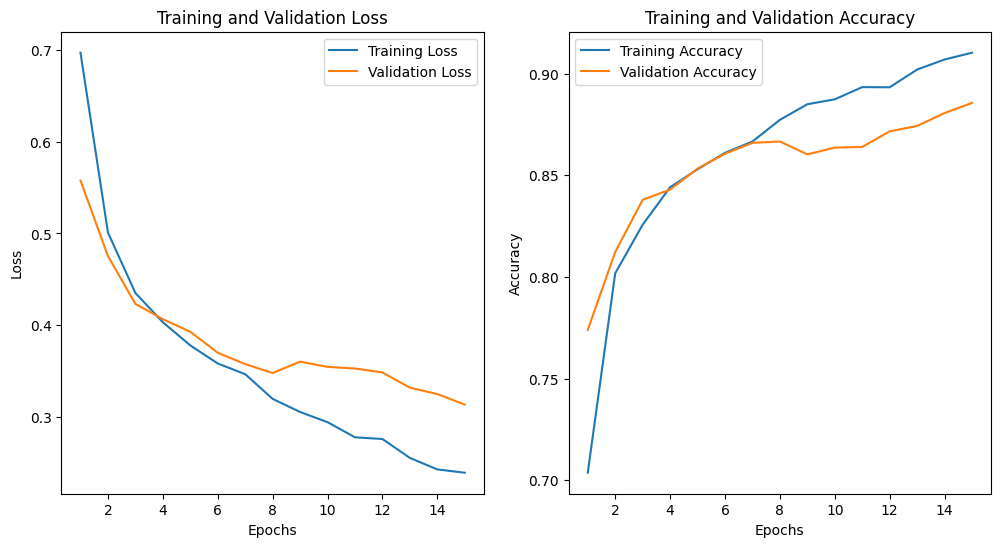

In [10]:
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Accuracy: 0.8803
Test F1-Score: 0.8805

Classification Report (Train):
              precision    recall  f1-score   support

    airplane       0.91      0.89      0.90      4000
  automobile       0.97      0.95      0.96      4000
        bird       0.89      0.93      0.91      4000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000


Classification Report (Validation):
              precision    recall  f1-score   support

    airplane       0.88      0.83      0.86      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.86      0.90      0.88      1000

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000


Classification Report (Test):
              precision    recall  f1-score   support

    airplane       0.85      0.84      

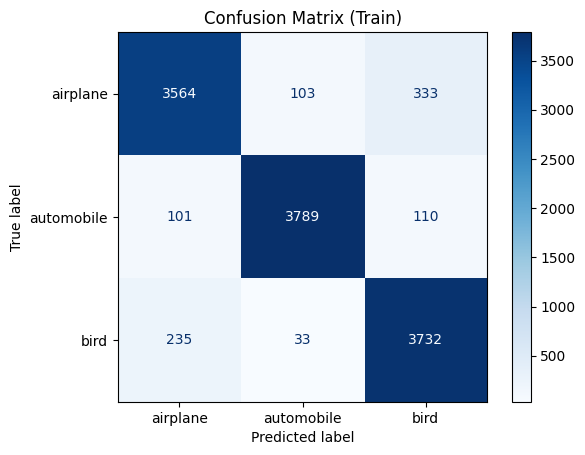


Confusion Matrix (Validation):


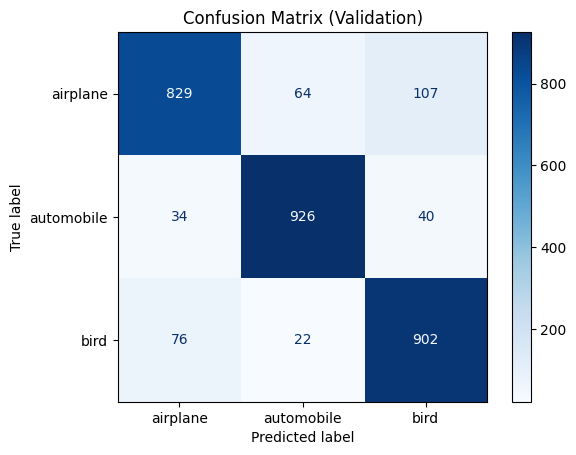


Confusion Matrix (Test):


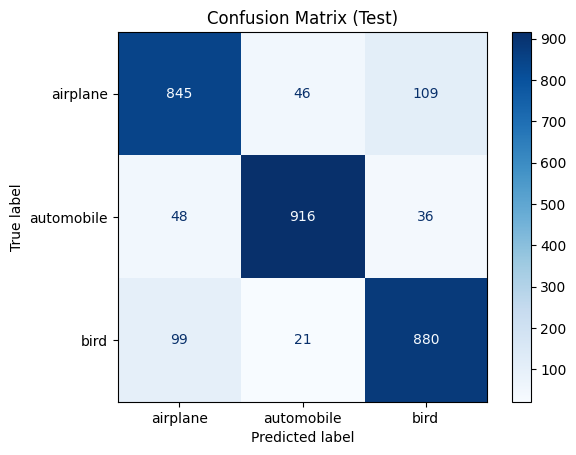

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    return np.array(all_labels), np.array(all_predictions)

train_labels, train_predictions = evaluate_model(train_loader, model)
val_labels, val_predictions = evaluate_model(val_loader, model)
test_labels, test_predictions = evaluate_model(test_loader, model)

test_accuracy = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print("\nClassification Report (Train):")
print(classification_report(train_labels, train_predictions, target_names=class_dict.values()))

print("\nClassification Report (Validation):")
print(classification_report(val_labels, val_predictions, target_names=class_dict.values()))

print("\nClassification Report (Test):")
print(classification_report(test_labels, test_predictions, target_names=class_dict.values()))

def plot_confusion_matrix(labels, predictions, dataset_name):
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_dict.values())
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

print("\nConfusion Matrix (Train):")
plot_confusion_matrix(train_labels, train_predictions, "Train")

print("\nConfusion Matrix (Validation):")
plot_confusion_matrix(val_labels, val_predictions, "Validation")

print("\nConfusion Matrix (Test):")
plot_confusion_matrix(test_labels, test_predictions, "Test")


<h3 align='center'>Part 6</h3>

In [12]:
class MLP(nn.Module):
    def __init__(self, num_classes=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 64)  
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  
        x = F.relu(self.fc1(x))  
        x = self.fc2(x) 
        return x

model_mlp = MLP(num_classes=len(class_dict))
# print(model_mlp)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

epochs = 15
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model_mlp.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    model_mlp.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_mlp(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

torch.save(model_mlp.state_dict(), "MLPmodel.pth")
print('Finished Training')


Epoch 1/15
  Training Loss: 0.6847, Training Accuracy: 0.7213
  Validation Loss: 0.6431, Validation Accuracy: 0.7420
Epoch 2/15
  Training Loss: 0.5529, Training Accuracy: 0.7783
  Validation Loss: 0.5960, Validation Accuracy: 0.7640
Epoch 3/15
  Training Loss: 0.5012, Training Accuracy: 0.8020
  Validation Loss: 0.6026, Validation Accuracy: 0.7673
Epoch 4/15
  Training Loss: 0.4553, Training Accuracy: 0.8234
  Validation Loss: 0.5823, Validation Accuracy: 0.7753
Epoch 5/15
  Training Loss: 0.4258, Training Accuracy: 0.8364
  Validation Loss: 0.5877, Validation Accuracy: 0.7780
Epoch 6/15
  Training Loss: 0.3952, Training Accuracy: 0.8499
  Validation Loss: 0.6106, Validation Accuracy: 0.7807
Epoch 7/15
  Training Loss: 0.3685, Training Accuracy: 0.8596
  Validation Loss: 0.6329, Validation Accuracy: 0.7810
Epoch 8/15
  Training Loss: 0.3417, Training Accuracy: 0.8700
  Validation Loss: 0.5751, Validation Accuracy: 0.7900
Epoch 9/15
  Training Loss: 0.3207, Training Accuracy: 0.8765
  

<h3 align='center'>Part 7</h3>

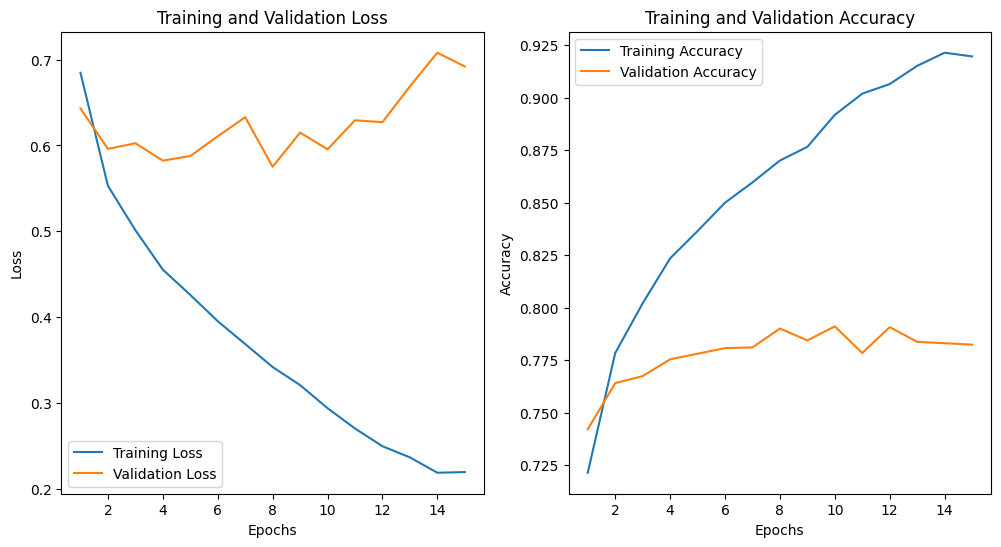

In [13]:
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Accuracy: 0.7910
Test F1-Score: 0.7920

Classification Report (Train):
              precision    recall  f1-score   support

    airplane       0.89      0.95      0.92      4000
  automobile       0.97      0.96      0.97      4000
        bird       0.96      0.90      0.93      4000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000


Classification Report (Validation):
              precision    recall  f1-score   support

    airplane       0.71      0.79      0.75      1000
  automobile       0.83      0.79      0.81      1000
        bird       0.82      0.77      0.80      1000

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000


Classification Report (Test):
              precision    recall  f1-score   support

    airplane       0.72      0.82      

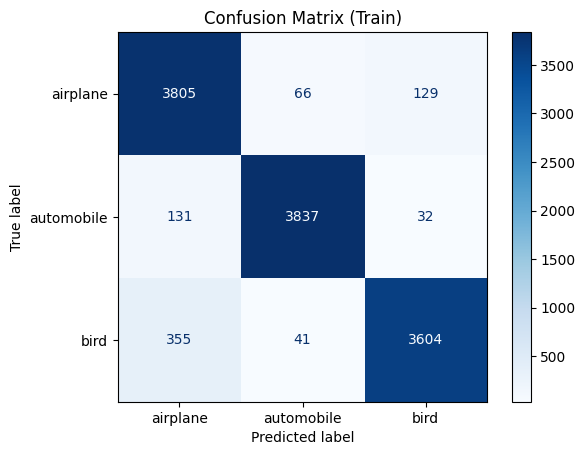


Confusion Matrix (Validation):


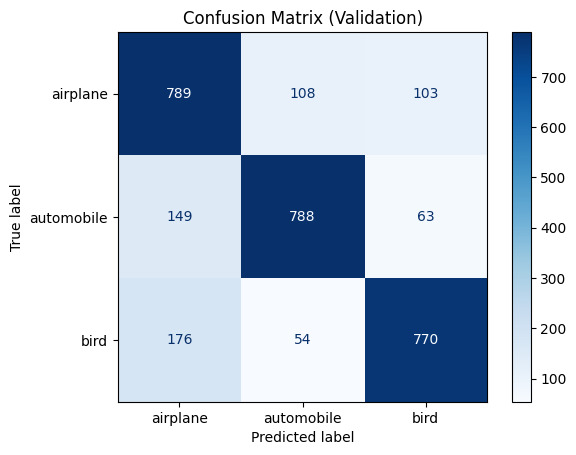


Confusion Matrix (Test):


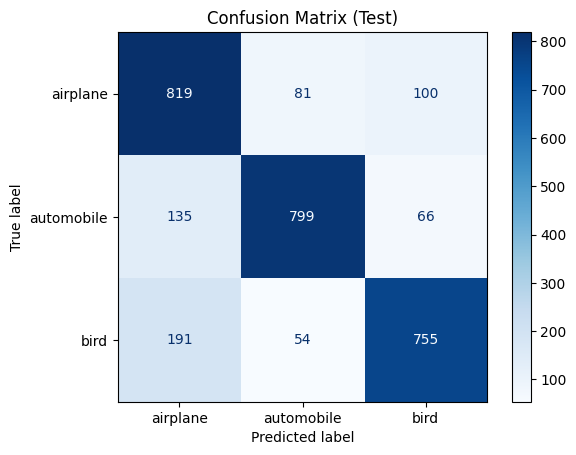

In [14]:
def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    return np.array(all_labels), np.array(all_predictions)

train_labels, train_predictions = evaluate_model(train_loader, model_mlp)
val_labels, val_predictions = evaluate_model(val_loader, model_mlp)
test_labels, test_predictions = evaluate_model(test_loader, model_mlp)

test_accuracy = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print("\nClassification Report (Train):")
print(classification_report(train_labels, train_predictions, target_names=class_dict.values()))

print("\nClassification Report (Validation):")
print(classification_report(val_labels, val_predictions, target_names=class_dict.values()))

print("\nClassification Report (Test):")
print(classification_report(test_labels, test_predictions, target_names=class_dict.values()))

def plot_confusion_matrix(labels, predictions, dataset_name):
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_dict.values())
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

print("\nConfusion Matrix (Train):")
plot_confusion_matrix(train_labels, train_predictions, "Train")

print("\nConfusion Matrix (Validation):")
plot_confusion_matrix(val_labels, val_predictions, "Validation")

print("\nConfusion Matrix (Test):")
plot_confusion_matrix(test_labels, test_predictions, "Test")